In [1]:
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from astropy.io import fits
from astropy.table import Table
import optuna
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score


/home/21953404Victor/SDC3/tutorial-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cargar los datos a partir de los archivos FITS
path_datos = "/home/21953404Victor/SDC3/SDC3GIT/data_actualizada/"
path_repo="/home/21953404Victor/SDC3/SDC3GIT/"
path = path_datos + "ZW3.msw_image.fits"
hdul = fits.open(path)

Transformación del catálogo de fuentes completo (almacenado)

In [3]:

# ruta_carpeta_catalogos = "/home/21953404Victor/SDC3/SDC3GIT/catalogos/catalogo completo 2/resultados/resultados_detection4"
# ruta_carpeta_resultados = "/home/21953404Victor/SDC3/SDC3GIT/catalogos/catalogo completo 2/labels"
# archivos = os.listdir(ruta_carpeta_catalogos)

# # Función para crear un archivo de anotación para cada catálogo
# def crear_anotaciones(path_cat, path_anotacion):
#     cat = Table.read(path_cat, format="ascii")
#     clase = "fuente"

#     with open(path_anotacion, "w") as f:
#         for row in cat:
#             x = row["X_IMAGE"]
#             y = row["Y_IMAGE"]
#             f.write(f"{x} {y} {clase}\n")

# # Procesar todos los archivos de catálogo en la carpeta
# for archivo in archivos:
#     # Extraer el número de kHz del nombre del archivo
#     num_khz = re.search(r"(\d+)kHz", archivo).group(1)

#     # Crear un nombre para el archivo de anotación correspondiente
#     anotacion_nombre = f"catalogo_completo_1_{num_khz}kHz.txt"

#     # Crear el archivo de anotación para el catálogo actual
#     crear_anotaciones(
#         os.path.join(ruta_carpeta_catalogos, archivo),
#         os.path.join(ruta_carpeta_resultados, anotacion_nombre)
#    )


In [3]:
import os
import numpy as np

ruta_carpeta_resultados = "/home/21953404Victor/SDC3/SDC3GIT/catalogos/catalogo completo 1/labels"
archivos = os.listdir(ruta_carpeta_resultados)

def clamp(value, min_value, max_value):
    return max(min(value, max_value), min_value)

def procesar_archivo(path_txt):
    with open(path_txt, "r") as f:
        lines = f.readlines()

    label = np.zeros((2048, 2048), dtype=int)

    for line in lines:
        x, y, _ = line.split()
        x, y = int(float(x)), int(float(y))

        x_coord = clamp(x, 0, 2047)
        y_coord = clamp(y, 0, 2047)
        label[y_coord, x_coord] = 1

    return label

# Crear una lista para guardar los datos procesados
target=[]

# Procesar todos los archivos de texto en la carpeta de resultados
for archivo in archivos:
    path_txt = os.path.join(ruta_carpeta_resultados, archivo)
    label = procesar_archivo(path_txt)
    target.append(label)



In [4]:
output_data = np.array(target).astype("float32")#[:, np.newaxis, :, :] # Agregar una dimensión para mantener el formato de los datos de entrada de la red neuronal
del target

In [5]:
# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
torch.cuda.empty_cache()

## Transformar los datos

In [8]:
probabilidad_imagen=np.mean(output_data)
print(probabilidad_imagen)

0.0004468742


In [9]:
# Cargar los datos y dividirlos en conjuntos de entrenamiento y validación
data = hdul[0].data

input_data = np.array(data).astype("float32") 
input_data=np.log10(((input_data - np.min(input_data)) / (np.max(input_data) - np.min(input_data))) + np.finfo(float).eps)

input_data = input_data.reshape((data.shape[0], 1, data.shape[1], data.shape[2]))

del hdul
del data

x_train, x_val, y_train, y_val = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

del input_data
del output_data

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).unsqueeze(1)
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val).unsqueeze(1)

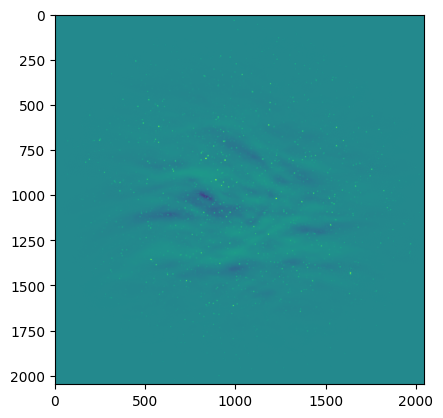

In [10]:
plt.imshow(x_train[0][0])

## Arquitectura

In [7]:
def create_decoder(dropout_rate, out_channels1, out_channels2, out_channels3):
    decoder = nn.Sequential(
        nn.ConvTranspose2d(out_channels3, out_channels2, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels2),
        nn.Dropout(dropout_rate),
        nn.ConvTranspose2d(out_channels2, out_channels1, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels1),
        nn.Dropout(dropout_rate),
        nn.ConvTranspose2d(out_channels1, 1, 3, padding=1),
        nn.Sigmoid()
    )
    return decoder.to(device)

def create_encoder(input_channels, num_filters1, num_filters2, dropout_rate, out_channels3):
    encoder = nn.Sequential(
        nn.Conv2d(input_channels, num_filters1, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_filters1),
        nn.MaxPool2d(2, 2),
        nn.Dropout(dropout_rate),
        nn.Conv2d(num_filters1, num_filters2, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_filters2),
        nn.MaxPool2d(2, 2),
        nn.Dropout(dropout_rate),
        nn.Conv2d(num_filters2, out_channels3, 3, padding=1),
        nn.ReLU(),
        nn.Dropout(dropout_rate)
    )
    return encoder.to(device)

In [13]:
np.shape(y_train)

torch.Size([720, 1, 2048, 2048])

In [14]:
np.shape(x_train)

torch.Size([720, 1, 2048, 2048])

### Optimizador de hiperparámetros

In [15]:
def objective(trial):
    # Cargar y dividir los datos en conjuntos de entrenamiento y validación
    train_data = TensorDataset(x_train, y_train)
    val_data = TensorDataset(x_val, y_val)

    # Crear DataLoaders para entrenamiento y validación
    batch_size = 1
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Hiperparámetros sugeridos por Optuna
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
    out_channels1 = trial.suggest_int("out_channels1", 16, 64)
    out_channels2 = trial.suggest_int("out_channels2", 16, 64)
    out_channels3 = trial.suggest_int("out_channels3", 16, 64)
    num_filters1 = trial.suggest_int("num_filters1", 16, 64)
    num_filters2 = trial.suggest_int("num_filters2", 16, 64)

    input_channels = 1
    encoder = create_encoder(input_channels, num_filters1, num_filters2, dropout_rate, out_channels3)
    decoder = create_decoder(dropout_rate, out_channels1, out_channels2, out_channels3)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

    num_epochs = 30
    best_roc_auc_score = 0

    train_losses = []
    val_losses = []
    auc_scores = []

    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()

        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            enc_output = encoder(images)
            dec_output = decoder(enc_output)

            labels_float = labels.float()

            loss = criterion(dec_output, labels_float)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        y_true, y_pred = [], []
        encoder.eval()
        decoder.eval()

        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                enc_output = encoder(images)
                dec_output = decoder(enc_output)
                dec_output = torch.squeeze(dec_output, dim=1)

                labels_float = labels.float()
                labels_float = torch.squeeze(labels_float, dim=1)

                loss = criterion(dec_output, labels_float)
                val_loss += loss.item()

                y_true.extend(labels_float.cpu().numpy())
                y_pred.extend(torch.sigmoid(dec_output).cpu().numpy())

            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            y_true_flat = np.reshape(y_true, (-1))
            y_pred_flat = np.reshape(y_pred, (-1))

            roc_auc = roc_auc_score(y_true_flat, y_pred_flat)
            auc_scores.append(roc_auc)

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}, ROC AUC: {roc_auc}")

            if roc_auc > best_roc_auc_score:
                best_roc_auc_score = roc_auc
                
                # Save the model
                decoder_path = f"modelos_intermedios/decoder_gpu_cat_completo_trial_{trial.number}.pt"
                encoder_path = f"modelos_intermedios/encoder_gpu_cat_completo_trial_{trial.number}.pt"

                torch.save(decoder.state_dict(), decoder_path)
                torch.save(encoder.state_dict(), encoder_path)

    # Clear the GPU
    del decoder
    del encoder
    torch.cuda.empty_cache()

    # Plotting training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.savefig(f"modelos_intermedios/loss_plot_trial_{trial.number}.png")
    plt.close()

    # Plotting ROC AUC scores
    plt.figure(figsize=(10, 5))
    plt.plot(auc_scores, label='ROC AUC Score')
    plt.legend(frameon=False)
    plt.savefig(f"modelos_intermedios/auc_plot_trial_{trial.number}.png")
    plt.close()

    return best_roc_auc_score


In [16]:
# Crear un estudio de optimización
study = optuna.create_study(direction="maximize") #ahora se intenta maximizar el AUC, no minimizarlo

# Ejecutar el estudio de optimización con la función 'objective' y un número determinado de ensayos
study.optimize(objective, n_trials=5)



[I 2023-05-28 12:09:50,953] A new study created in memory with name: no-name-fe371b2e-60d9-4dd4-8158-a5be44c446f1
/tmp/ipykernel_885405/2761579482.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_885405/2761579482.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)


Epoch 1/30, Train Loss: 0.7188352897763253, Validation Loss: 0.7051919662491393, ROC AUC: 0.49930268258636845
Epoch 2/30, Train Loss: 0.7025687103470166, Validation Loss: 0.702120327159186, ROC AUC: 0.5000947318688244
Epoch 3/30, Train Loss: 0.7020895404120286, Validation Loss: 0.7020613258056219, ROC AUC: 0.495364187267331
Epoch 4/30, Train Loss: 0.7020544099311034, Validation Loss: 0.7020443766815228, ROC AUC: 0.4957912835087778
Epoch 5/30, Train Loss: 0.7020418100059033, Validation Loss: 0.7020369366387635, ROC AUC: 0.49647105621331955
Epoch 6/30, Train Loss: 0.6985161426994536, Validation Loss: 0.6958058509378802, ROC AUC: 0.4944219666265696
Epoch 7/30, Train Loss: 0.6957966508136855, Validation Loss: 0.6957885866665708, ROC AUC: 0.4952798254351545
Epoch 8/30, Train Loss: 0.6957870704432328, Validation Loss: 0.6957846521014008, ROC AUC: 0.49793068627079534
Epoch 9/30, Train Loss: 0.6954270243644715, Validation Loss: 0.6937601958190539, ROC AUC: 0.5056930766225184
Epoch 10/30, Train

[I 2023-05-28 13:51:46,514] Trial 0 finished with value: 0.5056930766225184 and parameters: {'lr': 0.00036084047976713674, 'dropout_rate': 0.06970550838729356, 'out_channels1': 46, 'out_channels2': 30, 'out_channels3': 30, 'num_filters1': 22, 'num_filters2': 30}. Best is trial 0 with value: 0.5056930766225184.
/tmp/ipykernel_885405/2761579482.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_885405/2761579482.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)


Epoch 1/30, Train Loss: 0.7689040061500337, Validation Loss: 0.7335330758305544, ROC AUC: 0.8027722805331184
Epoch 2/30, Train Loss: 0.7136945320500268, Validation Loss: 0.7079198037721834, ROC AUC: 0.49801503315725226
Epoch 3/30, Train Loss: 0.707041046106153, Validation Loss: 0.7064132305139995, ROC AUC: 0.4946721946870342
Epoch 4/30, Train Loss: 0.7061890087193913, Validation Loss: 0.7059475450225956, ROC AUC: 0.4905154000390599
Epoch 5/30, Train Loss: 0.705865406493346, Validation Loss: 0.7057501739559912, ROC AUC: 0.4898599252086102
Epoch 6/30, Train Loss: 0.7057116587956747, Validation Loss: 0.7056460897566864, ROC AUC: 0.49240068449769636
Epoch 7/30, Train Loss: 0.7056291754047076, Validation Loss: 0.7055897791741302, ROC AUC: 0.4868724643949726
Epoch 8/30, Train Loss: 0.7055813137027952, Validation Loss: 0.7055564967308255, ROC AUC: 0.4893576283519177
Epoch 9/30, Train Loss: 0.7055518654485543, Validation Loss: 0.7055354483878415, ROC AUC: 0.4889726860544954
Epoch 10/30, Train 

[I 2023-05-28 15:39:44,517] Trial 1 finished with value: 0.8027722805331184 and parameters: {'lr': 8.258220774789589e-05, 'dropout_rate': 0.14009241848932386, 'out_channels1': 27, 'out_channels2': 50, 'out_channels3': 17, 'num_filters1': 19, 'num_filters2': 31}. Best is trial 1 with value: 0.8027722805331184.


Epoch 30/30, Train Loss: 0.693147305233611, Validation Loss: 0.6931471824645996, ROC AUC: 0.5057719033485878


/tmp/ipykernel_885405/2761579482.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_885405/2761579482.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)


Epoch 1/30, Train Loss: 0.7155292300714386, Validation Loss: 0.6987799676083728, ROC AUC: 0.3380183714554192
Epoch 2/30, Train Loss: 0.6966145821743541, Validation Loss: 0.6932634441233472, ROC AUC: 0.38010149201697974
Epoch 3/30, Train Loss: 0.6932344677547614, Validation Loss: 0.6931691163152621, ROC AUC: 0.6350331584481708
Epoch 4/30, Train Loss: 0.6931761692795488, Validation Loss: 0.6931562565308249, ROC AUC: 0.465473654607627
Epoch 5/30, Train Loss: 0.6931620356109407, Validation Loss: 0.6931518303096623, ROC AUC: 0.3452030931708543
Epoch 6/30, Train Loss: 0.6931572895911005, Validation Loss: 0.693149745464325, ROC AUC: 0.5669948114208393
Epoch 7/30, Train Loss: 0.6931546726160579, Validation Loss: 0.6931487677505662, ROC AUC: 0.4792548938218703
Epoch 8/30, Train Loss: 0.6931542484296693, Validation Loss: 0.6931483748868026, ROC AUC: 0.31830264057290225
Epoch 9/30, Train Loss: 0.6931525441507499, Validation Loss: 0.6931476593017578, ROC AUC: 0.40132206963934003
Epoch 10/30, Train

[I 2023-05-28 17:21:16,225] Trial 2 finished with value: 0.6350331584481708 and parameters: {'lr': 0.0007757547316216896, 'dropout_rate': 0.3190224520984825, 'out_channels1': 31, 'out_channels2': 18, 'out_channels3': 38, 'num_filters1': 23, 'num_filters2': 43}. Best is trial 1 with value: 0.8027722805331184.


Epoch 30/30, Train Loss: 0.6931478229661783, Validation Loss: 0.6931471824645996, ROC AUC: 0.49999964221280824


/tmp/ipykernel_885405/2761579482.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_885405/2761579482.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)


Epoch 1/30, Train Loss: 0.736590452823374, Validation Loss: 0.7137756910771955, ROC AUC: 0.49183221497760704
Epoch 2/30, Train Loss: 0.7057807879315482, Validation Loss: 0.713948102287166, ROC AUC: 0.48950654818262784
Epoch 3/30, Train Loss: 0.6992481442789237, Validation Loss: 0.6960899599349302, ROC AUC: 0.557825565600485
Epoch 4/30, Train Loss: 0.6958931257327398, Validation Loss: 0.6956959531452116, ROC AUC: 0.6741670505997438
Epoch 5/30, Train Loss: 0.695680504043897, Validation Loss: 0.6956322887984429, ROC AUC: 0.43359829531976385
Epoch 6/30, Train Loss: 0.6944132031665908, Validation Loss: 0.6938077106001628, ROC AUC: 0.788926391197555
Epoch 7/30, Train Loss: 0.6938192305465539, Validation Loss: 0.6937723492390543, ROC AUC: 0.786168422980665
Epoch 8/30, Train Loss: 0.693782037579351, Validation Loss: 0.6937618443320469, ROC AUC: 0.7837021923628247
Epoch 9/30, Train Loss: 0.6937678237756093, Validation Loss: 0.69375631427238, ROC AUC: 0.7829487589737262
Epoch 10/30, Train Loss: 

[I 2023-05-28 19:24:48,383] Trial 3 finished with value: 0.8203809803695286 and parameters: {'lr': 0.00017996145605171359, 'dropout_rate': 0.4860824373441544, 'out_channels1': 39, 'out_channels2': 40, 'out_channels3': 23, 'num_filters1': 43, 'num_filters2': 53}. Best is trial 3 with value: 0.8203809803695286.


Epoch 30/30, Train Loss: 0.6931476951473289, Validation Loss: 0.6931472420692444, ROC AUC: 0.49926737109364006


/tmp/ipykernel_885405/2761579482.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_885405/2761579482.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)


Epoch 1/30, Train Loss: 0.7277097177174356, Validation Loss: 0.7061801852442283, ROC AUC: 0.39636559246372466
Epoch 2/30, Train Loss: 0.7053768307798438, Validation Loss: 0.7033306136315699, ROC AUC: 0.3367011728764219
Epoch 3/30, Train Loss: 0.7023081629640526, Validation Loss: 0.7022373761919981, ROC AUC: 0.47614437854224817
Epoch 4/30, Train Loss: 0.7022203818791443, Validation Loss: 0.7022021778380674, ROC AUC: 0.4403765479999079
Epoch 5/30, Train Loss: 0.6984094493091106, Validation Loss: 0.6960077028906806, ROC AUC: 0.3430059069311069
Epoch 6/30, Train Loss: 0.6958754758867952, Validation Loss: 0.6958944718482086, ROC AUC: 0.34036152284760923
Epoch 7/30, Train Loss: 0.6958591016630332, Validation Loss: 0.6958783400651499, ROC AUC: 0.34930813749343914
Epoch 8/30, Train Loss: 0.6946807755364313, Validation Loss: 0.6931662118237322, ROC AUC: 0.5412911561195279
Epoch 9/30, Train Loss: 0.6931702065798971, Validation Loss: 0.6931522686178513, ROC AUC: 0.4323255538857289
Epoch 10/30, Tr

[I 2023-05-28 21:16:43,879] Trial 4 finished with value: 0.5412911561195279 and parameters: {'lr': 0.0004415264664420704, 'dropout_rate': 0.1184728375255536, 'out_channels1': 21, 'out_channels2': 35, 'out_channels3': 46, 'num_filters1': 24, 'num_filters2': 57}. Best is trial 3 with value: 0.8203809803695286.


Epoch 30/30, Train Loss: 0.6931471895840433, Validation Loss: 0.6931471824645996, ROC AUC: 0.49999952295041095


In [24]:
with open('study.pkl', 'wb') as f:
    pickle.dump(study, f)

# post entrenamiento

In [18]:
with open('study.pkl', 'rb') as f:
    study = pickle.load(f)

print("Mejor prueba: ")
print(study.best_trial)

print("\nMejores hiperparámetros: ")
print(study.best_trial.params)

Mejor prueba: 
FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.8203809803695286], datetime_start=datetime.datetime(2023, 5, 28, 17, 21, 16, 226622), datetime_complete=datetime.datetime(2023, 5, 28, 19, 24, 48, 383640), params={'lr': 0.00017996145605171359, 'dropout_rate': 0.4860824373441544, 'out_channels1': 39, 'out_channels2': 40, 'out_channels3': 23, 'num_filters1': 43, 'num_filters2': 53}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'out_channels1': IntDistribution(high=64, log=False, low=16, step=1), 'out_channels2': IntDistribution(high=64, log=False, low=16, step=1), 'out_channels3': IntDistribution(high=64, log=False, low=16, step=1), 'num_filters1': IntDistribution(high=64, log=False, low=16, step=1), 'num_filters2': IntDistribution(high=64, log=False, low=16, step=1)}, trial_id=3, value=None)

Me

In [19]:
# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print("Tasa de aprendizaje:", study.best_params["lr"])
print("Tasa de dropout:", study.best_params["dropout_rate"])
print("Número de filtros en la primera capa convolucional del encoder:", study.best_params["num_filters1"])
print("Número de filtros en la segunda capa convolucional del encoder:", study.best_params["num_filters2"])
print("Número de canales en la primera capa del decoder:", study.best_params["out_channels1"])
print("Número de canales en la segunda capa del decoder:", study.best_params["out_channels2"])
print("Número de canales en la tercera capa del decoder:", study.best_params["out_channels3"])

# Obtener el número del mejor ensayo
best_trial_number = study.best_trial.number

# Crear un nuevo 'decoder' y 'encoder' con los mejores hiperparámetros encontrados
decoder = create_decoder(
    study.best_params["dropout_rate"],
    study.best_params["out_channels1"],
    study.best_params["out_channels2"],
    study.best_params["out_channels3"])

encoder = create_encoder(
    1, # número de canales de entrada
    study.best_params["num_filters1"],
    study.best_params["num_filters2"],
    study.best_params["dropout_rate"],
    study.best_params["out_channels3"]
    )

# Cargar los estados de los mejores modelos
decoder_path = f"modelos_intermedios/decoder_gpu_cat_completo_trial_{best_trial_number}.pt"
encoder_path = f"modelos_intermedios/encoder_gpu_cat_completo_trial_{best_trial_number}.pt"

decoder.load_state_dict(torch.load(decoder_path))
encoder.load_state_dict(torch.load(encoder_path))

Mejores hiperparámetros encontrados:
Tasa de aprendizaje: 0.00017996145605171359
Tasa de dropout: 0.4860824373441544
Número de filtros en la primera capa convolucional del encoder: 43
Número de filtros en la segunda capa convolucional del encoder: 53
Número de canales en la primera capa del decoder: 39
Número de canales en la segunda capa del decoder: 40
Número de canales en la tercera capa del decoder: 23


<All keys matched successfully>

In [20]:
df = pd.DataFrame()
for i, trial in enumerate(study.trials, 1):
    row = trial.params
    row['loss last 20'] = round(trial.value, 4)
    row['rank'] = i
    row['nº ensayo'] = str(trial.number)
    if 'channels' in row:
        row['ch.'] = row.pop('channels')
    if 'filters' in row:
        row['filt.'] = row.pop('filters')
    if 'lr' in row:
        row['learning rate'] = round(row.pop('lr'), 4)
    df = df.append(row, ignore_index=True)

for col in df.columns:
    if df[col].dtype.kind in 'fc':
        df[col] = df[col].round(4)

df = df.sort_values(by='loss last 20')
df['rank'] = range(1, len(df) + 1)
df.set_index('rank', inplace=True)


/tmp/ipykernel_885405/3381394901.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/tmp/ipykernel_885405/3381394901.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/tmp/ipykernel_885405/3381394901.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/tmp/ipykernel_885405/3381394901.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/tmp/ipykernel_885405/3381394901.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

In [21]:
# Guarda el DataFrame como un archivo Excel
df.to_excel('ranking_modelos.xlsx', index=False, engine="openpyxl")


## Métricas

In [8]:
with open('study.pkl', 'rb') as f:
    study = pickle.load(f)

# Obtener el número del mejor ensayo
best_trial_number = study.best_trial.number

# Crear un nuevo 'decoder' y 'encoder' con los mejores hiperparámetros encontrados
decoder = create_decoder(
    study.best_params["dropout_rate"],
    study.best_params["out_channels1"],
    study.best_params["out_channels2"],
    study.best_params["out_channels3"])

encoder = create_encoder(
    1, # número de canales de entrada
    study.best_params["num_filters1"],
    study.best_params["num_filters2"],
    study.best_params["dropout_rate"],
    study.best_params["out_channels3"]
    )

# Cargar los estados de los mejores modelos
decoder_path = f"modelos_intermedios/decoder_gpu_cat_completo_trial_{best_trial_number}.pt"
encoder_path = f"modelos_intermedios/encoder_gpu_cat_completo_trial_{best_trial_number}.pt"


In [9]:
# Cargar los datos y dividirlos en conjuntos de entrenamiento y validación
data = hdul[0].data

input_data = np.array(data).astype("float32") 
input_data=np.log10(((input_data - np.min(input_data)) / (np.max(input_data) - np.min(input_data))) + np.finfo(float).eps)

input_data = input_data.reshape((data.shape[0], 1, data.shape[1], data.shape[2]))

del hdul
del data

x_train, x_val, y_train, y_val = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

del input_data
del output_data

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).unsqueeze(1)
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val).unsqueeze(1)

In [10]:
torch.cuda.empty_cache()

In [11]:
# Definir los umbrales
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

# Crear un DataLoader con lotes de 20 imágenes
batch_size = 5
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Almacenar las métricas para cada umbral
metrics = {threshold: {"precision": [], "recall": [], "f1": [], "specificity": []} for threshold in thresholds}

# Establecer el modelo en modo de evaluación
encoder.eval()
decoder.eval()


Sequential(
  (0): ConvTranspose2d(23, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.4860824373441544, inplace=False)
  (4): ConvTranspose2d(40, 39, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(39, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.4860824373441544, inplace=False)
  (8): ConvTranspose2d(39, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Sigmoid()
)

In [ ]:
# Iterar sobre los lotes de datos
for i, (x_batch, y_batch) in enumerate(val_loader):
    with torch.no_grad():
        x_batch = x_batch.to(device)
        enc_output = encoder(x_batch)
        y_pred = decoder(enc_output).cpu()

        # Iterar sobre los umbrales
        for threshold in thresholds:
            y_pred_bin = (y_pred > threshold).numpy()

            # Calcular la matriz de confusión
            cm = confusion_matrix(y_batch.numpy().flatten(), y_pred_bin.flatten())

            # Calcular las métricas de interés
            precision = precision_score(y_batch.numpy().flatten(), y_pred_bin.flatten(), zero_division=1)

            recall = recall_score(y_batch.numpy().flatten(), y_pred_bin.flatten())
            f1 = f1_score(y_batch.numpy().flatten(), y_pred_bin.flatten())

            # Especificidad: (Verdaderos negativos) / (Verdaderos negativos + Falsos positivos)
            specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

            # Almacenar las métricas
            metrics[threshold]["precision"].append(precision)
            metrics[threshold]["recall"].append(recall)
            metrics[threshold]["f1"].append(f1)
            metrics[threshold]["specificity"].append(specificity)

    # Liberar la memoria ocupada por las variables que ya no se utilizan
    del x_batch
    del y_batch
    del y_pred
    del y_pred_bin
    del enc_output
    torch.cuda.empty_cache()

    # Imprimir el progreso
    if i % 10 == 0:  # Cambia este número si deseas ver las actualizaciones más o menos frecuentemente
        print(f"Procesado lote {i} de {len(val_loader)}")

print("Finalizado.")


Procesado lote 0 de 37


In [ ]:
# Calcular la media de las métricas para cada umbral
results = {}  # Diccionario para almacenar resultados
for threshold in thresholds:
    print(f"\nUmbral: {threshold}")
    results[threshold] = {}  # Diccionario para almacenar resultados de un umbral
    for metric, values in metrics[threshold].items():
        mean_value = np.mean(values)
        print(f"{metric.capitalize()}: {mean_value}")
        results[threshold][metric] = mean_value  # Almacenar resultado

# Crear DataFrame con resultados
df_results = pd.DataFrame(results)

# Dibujar las gráficas de barras
fig, ax = plt.subplots(4, 1, figsize=(10, 20))
for i, metric in enumerate(["precision", "recall", "f1", "specificity"]):
    mean_values = [np.mean(metrics[threshold][metric]) for threshold in thresholds]
    ax[i].bar([str(threshold) for threshold in thresholds], mean_values)
    ax[i].set_ylabel(metric.capitalize())
    ax[i].set_xlabel("Umbral")
    ax[i].set_title(f"{metric.capitalize()} vs Umbral")

plt.tight_layout()
plt.show()


In [ ]:
df_results.to_csv("Metricas.csv")

In [1]:
import pandas as pd
df_results=pd.read_csv("Metricas.csv")
df_results.head()

,Unnamed: 0,0.5,0.6,0.7,0.8,0.9
0,precision,0.000446,1.0,1.0,1.0,1.0
1,recall,1.000000,0.0,0.0,0.0,0.0
2,f1,0.000892,0.0,0.0,0.0,0.0
3,specificity,0.000000,1.0,1.0,1.0,1.0
